In [11]:
# set this variable with one of the following values

# -> 'local'
# -> 'docker_container'
# -> 'docker_cluster'

CLUSTER_TYPE ='local'

In [13]:
import findspark

findspark.init('/home/prody/Documents/spark-3.2.1-bin-hadoop3.2/')

In [14]:
# check some of the env variables
!env | grep -i spark

PWD=/home/prody/MAPD-B/MAPD-B/spark/notebooks
PYSPARK_PYTHON=/home/prody/anaconda3/bin/python
SPARK_HOME=/home/prody/Documents/spark-3.2.1-bin-hadoop3.2/


In [15]:
!$SPARK_HOME/sbin/start-master.sh --host localhost --port 7077 --webui-port 8080

starting org.apache.spark.deploy.master.Master, logging to /home/prody/Documents/spark-3.2.1-bin-hadoop3.2//logs/spark-prody-org.apache.spark.deploy.master.Master-1-prody-pc.out


In [16]:
!$SPARK_HOME/sbin/start-worker.sh spark://localhost:7077 --cores 2 --memory 2g

starting org.apache.spark.deploy.worker.Worker, logging to /home/prody/Documents/spark-3.2.1-bin-hadoop3.2//logs/spark-prody-org.apache.spark.deploy.worker.Worker-1-prody-pc.out


In [17]:
from pyspark.sql import SparkSession

# if Spark is run either in Local of Single-Container mode
if CLUSTER_TYPE in ['local', 'docker_container']:
    
    # build a SparkSession 
    #   connect to the master node (address `localhost`) and the port where the master node is listening (7077)
    #   declare the app name 
    #   either connect or create a new context
    spark = SparkSession.builder \
        .master("spark://localhost:7077")\
        .appName("First spark application")\
        .getOrCreate()

# if Spark is run as Docker Container cluster (with docker-compose)
elif CLUSTER_TYPE == 'docker_cluster':
    
    # build a SparkSession 
    #   connect to the master node (address `spark-master`) and the port where the master node is listening (7077)
    #   declare the app name 
    #   configure the executor memory to 512 MB
    #   either connect or create a new context
    spark = SparkSession.builder \
        .master("spark://spark-master:7077")\
        .appName("First spark application")\
        .config("spark.executor.memory", "512m")\
        .getOrCreate()
else:
    print("Variable CLUSTER_TYPE is not set.")


22/06/10 13:39:45 WARN Utils: Your hostname, prody-pc resolves to a loopback address: 127.0.1.1; using 192.168.144.128 instead (on interface wlp3s0)
22/06/10 13:39:45 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/06/10 13:39:46 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Check the content of the SparkSession `spark` object

In [18]:
spark

Get the SparkContext object from the SparkSession 

The SparkContext is the main entry point for all Spark functionalities, and it is used to work with RDDs

In [19]:
sc = spark.sparkContext
sc

<SparkContext master=spark://localhost:7077 appName=First spark application>

In [29]:
import numpy as np

# generate mock dataset
c_1 = np.random.normal(0.5, 0.2, (100, 2))
c_2 = np.random.normal(1.0, 0.2, (100, 2))
c_3 = np.random.normal(-0.5, 0.2, (100, 2))
X = np.concatenate((c_1,c_2,c_3))

import numpy as np
# 1: Given: k, mini-batch size b, iterations t, data set X
# 2: Initialize each c ∈ C with an x picked randomly from X
# 3: v ← 0
k = 3
b = 25
t = 50000
C = np.array([X[np.random.randint(0, len(X))] for _ in range(k)])
v = np.zeros(len(C))
Y = np.empty(len(X), dtype=np.int32)

In [ ]:
def find_min(idx):
    distances = [np.linalg.norm(X[idx] - centroid, 2) for centroid in C]
    return np.argmin(distances)

In [53]:
def update_centroids(c):
    # trying to create a function to use with spark in order to compute the new centroids in the second for
    c_idx = np.where(C == c)[0]
    v[c_idx] += 1
    learning_rate = 1 / v[c_idx]
    c = (1 - learning_rate) * c + learning_rate * X[idx]
     

93111.0

In [57]:
mini_batch_idx = np.random.choice(range(len(X)), size=b, replace=False)
mini_batch = X[mini_batch_idx]
dist_mini_batch_idx = sc.parallelize(mini_batch_idx)
Y[mini_batch_idx] = dist_mini_batch_idx.map(find_min).collect()
# dist_C = sc.parallelize(C)
# dist_C
# I am stuck here 

ParallelCollectionRDD[22925] at readRDDFromFile at PythonRDD.scala:274

In [45]:
# dist_data.map(lambda x: x + 1).collect()
# count_circle = points_rdd \
#     .map(lambda r: random.random() ** 2 + random.random() ** 2) \
#     .filter(lambda r: r < 1) \
#     .count()
# points_in_circle = points_rdd.map(in_circle).reduce(lambda x, y: x + y)



# 4: for i = 1 to t do
# 5: M ← b examples picked randomly from X

use_spark = True

import time

tic = time.time()

for i in range(t):
    mini_batch_idx = np.random.choice(range(len(X)), size=b, replace=False)
    
    # 6: for x ∈ M do
    # 7: d[x] ← f (C, x) // Cache the center nearest to x
    # 8: end for
    # 9: for x ∈ M do
    # 10: c ← d[x] // Get cached center for this x
    # 11: v[c] ← v[c] + 1 // Update per-center counts
    # 12: η ← 1/v[c] // Get per-center learning rate
    # 13: c ← (1 − η)c + ηx // Take gradient step
    # 14: end for
    # 15: end for
    
    if use_spark is True:
        # I am still working on the second for (to compute the new centroids)
        mini_batch = X[mini_batch_idx]
        dist_mini_batch_idx = sc.parallelize(mini_batch_idx)
        Y[mini_batch_idx] = dist_mini_batch_idx.map(find_min).collect()
        v[Y[idx]] = dist_mini_batch_idx.map().collect()
        # not finished
        
    else:    
        # this is classic interpretion (https://www.eecs.tufts.edu/~dsculley/papers/fastkmeans.pdf)
        for idx in mini_batch_idx:
            Y[idx] = find_min(X[idx])
        for idx in mini_batch_idx:
            v[Y[idx]] += 1
            learning_rate = 1 / v[Y[idx]]
            C[Y[idx]] = (1 - learning_rate) * C[Y[idx]] + learning_rate * X[idx]
     


        
toc = time.time()
print('Computation time: ', toc - tic, ' seconds')

ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/home/prody/Documents/spark-3.2.1-bin-hadoop3.2/python/lib/py4j-0.10.9.3-src.zip/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/home/prody/Documents/spark-3.2.1-bin-hadoop3.2/python/lib/py4j-0.10.9.3-src.zip/py4j/clientserver.py", line 475, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/home/prody/anaconda3/lib/python3.9/socket.py", line 704, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: 

In [97]:
Y

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], d

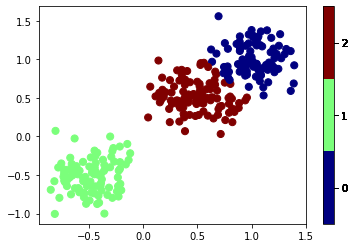

In [102]:
from matplotlib import pyplot as plt
import matplotlib.colors as colors

# Define a colormap with the right number of colors
cmap = plt.cm.get_cmap('jet',max(Y)-min(Y)+1)

bounds = range(min(Y),max(Y)+2)
norm = colors.BoundaryNorm(bounds, cmap.N)

plt.scatter(X[:,0], X[:,1], c=Y, s=50, cmap=cmap, norm=norm)

# Add a colorbar. Move the ticks up by 0.5, so they are centred on the colour.
cb=plt.colorbar(ticks=np.array(Y)+0.5)
cb.set_ticklabels(Y)

plt.show()

# Stop worker and master

In [7]:
# stop the running Spark context
sc.stop()

NameError: name 'sc' is not defined

In [8]:
# stop the running Spark session
spark.stop()

NameError: name 'spark' is not defined

### Stop Spark services - Local cluster

To stop the Spark execution in the master and worker nodes, issue the following bash commands

In [9]:
!$SPARK_HOME/sbin/stop-worker.sh

stopping org.apache.spark.deploy.worker.Worker


In [10]:
!$SPARK_HOME/sbin/stop-master.sh

stopping org.apache.spark.deploy.master.Master


### Stop Spark services - Docker container(s)

For the single Docker container, it is sufficient to stop and close the running container.

For the Docker cluster, use `docker-compose down` to stop and clear all running containers.